
# Part l: Manipulating Financial Data in Python

##Utility Functions
```
symbol_to_path(symbol, base_dir = os.path.join("..", "data"))
        return CSV file path of specific symbol (stock name) in local directory.
```
```
get_data(symbols, dates, adSPY = True):
        Read stock data (adjusted close) for given symbols from CSV files.
```
```
plot_data(df, title = "Stock Prices", xlabel = 'Date', ylabel = 'Price'):
        Plot stock prices with a custom title and meaningful axis labels.
``` 

##Assessing Portfolios
```
calculate_daily_return(port_daily_value):
        Compute daily return. 
```
```
get_portfolio_stats(port_daily_value, dr, rfr, sf = 252):
        Compute portfolio statistics. Return cr, adr, sddr, sr, ev.
```
```
normalized(prices):
        Normalize the input dataframe. 
```
```
assess_portfolio(sd, ed, syms, allocs, sv = 1000000, rfr = 0.0, sf = 252.0, gen_plot = True):
        Compute portfolio statistics and plot line chart comparing to S&P 500 given the description of portfolio. 
        Return cr, adr, sddr, sr, ev
```

##Optimizing Portfolios
```
opitimize_portfolio(sd, ed, syms, gen_plot = True):
        Compute optimal allocations for a given set of stocks by  maximizing Sharpe ratio and 
        generate portfolio statistics for the optimal portfolio. In additon, plot line chart comparing to S&P 500.
```
#Part II: Market Simulator
```
compute_portvals(orders_file = "./orders/orders.csv", start_val = 1000000)
        Create a market simulator that accepts trading orders, keeps track of a portfolio's value over time 
        and assesses the performance of that portfolio.
```
#Partlll: Backtesting Techinical Indicators

##Bollinger Bands
```
generate_orders_csv(df, syms, shares, column = 'Order'):        
        Generate orders from a trading strategies for market simulator
```
```
boolinger_strategy(sd, ed, syms, N = 20)
```
##Moving Average Convergence/Divergence (MACD)
```
EMA(prices, N)
```
```
MACD_strategy(sd, ed, syms)
```

In [2]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
% matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Part I: Manipulating Finacial Data in Python

Define three utility functions 

In [3]:
def symbol_to_path(symbol, base_dir = os.path.join("..", "data")):
    """return CSV file path of specific symbol (stock name) in local directory"""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates, adSPY = True):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index = dates)
    
    # add S&P 500 to the data if reqiured and missing
    if 'SPY' not in symbols and adSPY:
        symbols = ["SPY"] + symbols
        
    for symbol in symbols:
        df_symbol = pd.read_csv(symbol_to_path(symbol), index_col = 'Date', parse_dates = True,
                               usecols=['Date', 'Adj Close'], na_values=['nan'])
        # rename the column so as to avoid error of same column name
        df_symbol = df_symbol.rename(columns = {"Adj Close":symbol})
        df = df.join(df_symbol)
        df = df.dropna()
    return df

def plot_data(df, title = "Stock Prices", xlabel = 'Date', ylabel = 'Price'):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

## Assess Portfolios


In [4]:
def calculate_daily_return(port_daily_value):
    """Helper function. Compute daily return. 
    Parameters
    ----------
        port_daily_value: DataFrame, the daily value of the portfolio
        
    Returns
    -------
       dr: daily return"""
    dr = port_daily_value.copy()
    dr[1:] = (port_daily_value[1:] / port_daily_value[0:-1].values) -1 
    
    #first day return is arbitragely set to 0, we will exclude it when calculating average return
    dr[0] = 0.0
    return dr

def get_portfolio_stats(port_daily_value, dr, rfr, sf = 252):
    """ Helper function. Compute portfolio statistics. 
    Parameters
    ----------
        port_daily_value: DataFrame, the daily value of the portfolio
        dr: daily return
        rfr: risk free rate
        sf: sampling frequency, by default set to 252 days 
       
    Returns
    -------
        cr: cumulative return 
        adr: average period return (equals to average daily return if sf = 252) 
        sddr: standard deviation of daily returns
        sr: sharpe ratio
        ev: ending value of the portfolio"""

    
    #Exclude the first value 0 to ensure the rest value would be correct
    dr = dr.iloc[1:]
    
    # Average daily return
    adr = np.mean(dr)
   
    # Cumulative return
    cr = (port_daily_value[-1] / port_daily_value[0]) -1
    
    # Standard deviation of daily return, we should use sample std instead of population
    sddr = np.std(dr, ddof = 1)
    
    
    #Sharpe Ratio : mean(daily returns - risk free rate) / standard deviation of daily return * sqrt(sampling frequency)
    k = sf ** 0.5
    sr = (adr-rfr)/ sddr * k
    
    # Ending Value
    ev = port_daily_value[-1]
    
    
    return adr, cr, sddr, sr, ev
    
def normalized(prices):
    # normalize the input dataframe
    return prices / prices.ix[0]
    
def assess_portfolio(sd, ed, syms, allocs, sv = 1000000, rfr = 0.0, sf = 252.0, gen_plot = True):
    """Compute portfolio statistics and plot line chart comparing to S&P 500 given the description of portfolio.
    Parameters
    ----------
        sd: first date to track
        ed: last date to track
        syms: symbols, a list of stock names
        sv: starting value of the portfolio
        rfr: risk free rate
        sf: sampling frequency, by default set to 252 days 
        gen_plot: wheather or not to plot normalized price chart
        
    Returns
    -------
        cr: cumulative return 
        adr: average period return (equals to average daily return if sf = 252) 
        sddr: standard deviation of daily returns
        sr: sharpe ratio
        ev: ending value of the portfolio"""

    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    prices_all = get_data(syms, dates)
    prices_syms = prices_all[syms] # only portfolio symbols
    prices_spy = prices_all['SPY']  # only SPY, for comparison later
    
    
    
    # Get daily portfolio value
    normalized_syms = normalized(prices_syms)
    allocated_port = normalized_syms * allocs
    port = allocated_port * sv
    port_daily_value = port.sum(axis = 1) #sum up each row
    
    # normalization for comparision and plotting
    normalized_spy = normalized(prices_spy) 
    normalized_port = normalized(port_daily_value) 
    
    dr = calculate_daily_return(port_daily_value)
    
    adr, cr, sddr, sr, ev = get_portfolio_stats(port_daily_value, dr, rfr, sf)
    
    
    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        # add code to plot here
        
        df_temp = pd.concat([normalized_port, normalized_spy], keys=['Portfolio', 'SPY'], axis=1)
        plot_data(df_temp)
        
        print "Start Date:", sd#sd.strftime('%Y-%m-%d')
        print "End Date:", ed#ed.strftime('%Y-%m-%d')
        print "Symbols:", syms
        print "Allocations:", allocs, "\n"
        
    
        print "Cumulative Return: ", cr
        print "Average Daily Return: ", adr
        print "Volatility (stdev of daily returns): ", sddr
        print "Sharpe Ratio: ", sr
        print "End Value of Portfolio: ", ev, "\n" 
        
        print prices_all.head()
    
    return cr, adr, sddr, sr, ev
    

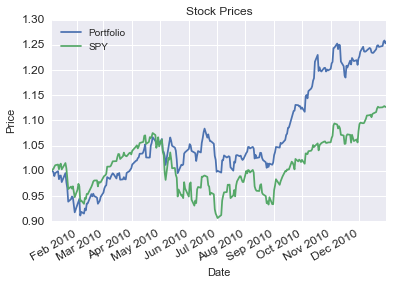

Start Date: 2010-01-01
End Date: 2010-12-31
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Allocations: [0.2, 0.3, 0.4, 0.1] 

Cumulative Return:  0.255646784534
Average Daily Return:  0.000957366234238
Volatility (stdev of daily returns):  0.0100104028
Sharpe Ratio:  1.51819243641
End Value of Portfolio:  1255646.78453 

               SPY    GOOG    AAPL     GLD    XOM
2010-01-04  108.27  626.75  213.10  109.80  64.55
2010-01-05  108.56  623.99  213.46  109.70  64.80
2010-01-06  108.64  608.26  210.07  111.51  65.36
2010-01-07  109.10  594.10  209.68  110.82  65.15
2010-01-08  109.46  602.02  211.07  111.37  64.89


(0.25564678453350465,
 0.0009573662342381413,
 0.010010402800015368,
 1.518192436412635,
 1255646.7845335046)

In [5]:
assess_portfolio(sd = '2010-01-01', ed = '2010-12-31', syms = ['GOOG', 'AAPL', 'GLD', 'XOM'], 
                 allocs = [0.2, 0.3, 0.4, 0.1], sv = 1000000, rfr = 0.0, sf = 252.0, gen_plot = True)

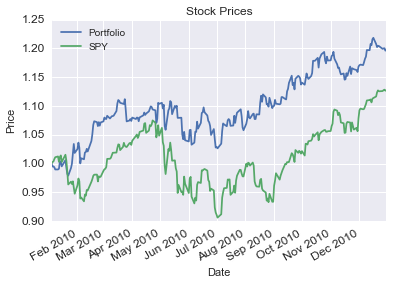

Start Date: 2010-01-01
End Date: 2010-12-31
Symbols: ['AXP', 'HPQ', 'IBM', 'HNZ']
Allocations: [0.0, 0.0, 0.0, 1.0] 

Cumulative Return:  0.198105963655
Average Daily Return:  0.000763106152672
Volatility (stdev of daily returns):  0.00926153128768
Sharpe Ratio:  1.30798398744
End Value of Portfolio:  1198105.96365 

               SPY    AXP    HPQ     IBM    HNZ
2010-01-04  108.27  39.15  50.36  126.24  39.07
2010-01-05  108.56  39.06  50.57  124.71  38.87
2010-01-06  108.64  39.69  50.10  123.90  38.88
2010-01-07  109.10  40.33  50.12  123.47  38.82
2010-01-08  109.46  40.31  50.49  124.71  38.67


(0.19810596365497823,
 0.0007631061526720289,
 0.00926153128768457,
 1.3079839874416062,
 1198105.9636549782)

In [6]:
assess_portfolio(sd = '2010-01-01', ed = '2010-12-31', syms = ['AXP', 'HPQ', 'IBM', 'HNZ'], 
                 allocs = [0.0, 0.0, 0.0, 1.0], sv = 1000000, rfr = 0.0, sf = 252.0, gen_plot = True)

# Optimizing Portfolios

In [7]:
import scipy.optimize as spo

def opitimize_portfolio(sd, ed, syms, gen_plot = True):
    """Compute optimal allocations for a given set of stocks by  maximizing Sharpe ratio and generate portfolio statistics
       for the optimal portfolio. In additon, plot line chart comparing to S&P 500.
    Parameters
    ----------
        sd: first date to track
        ed: last date to track
        syms: symbols, a list of stock names
        gen_plot: wheather or not to plot normalized price chart
        
    Returns
    -------
        cr: cumulative return 
        adr: average period return (equals to average daily return if sf = 252) 
        sddr: standard deviation of daily returns
        sr: sharpe ratio
        ev: ending value of the portfolio"""
    
    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    prices_all = get_data(syms, dates)
    prices_syms = prices_all[syms] # only portfolio symbols
    prices_spy = prices_all['SPY']  # only SPY, for comparison later
    
    
    def inverse_sr(allocs):
        sr= assess_portfolio(sd = sd, ed = ed, syms = syms, allocs = allocs, gen_plot = False)[3]
        
        return 1 / sr


    def get_optimize_allocations(f, initial_allocs):
        """Helper function. Compute optimized allocation.
        Parameters
        ----------
            f: function to minimize
            initial_allocs: initial guess of allocations
        Returns
        -------
            min_result: optimized allocation that provides highest sharpe ratio"""    
        bounds = [tuple((0, 1)) for i in initial_allocs]
        constraints = ({'type' : 'eq', 'fun' : lambda x: 1.0 - np.sum(x)})
    
        min_result = spo.minimize(fun = f, x0 = initial_allocs, method = "SLSQP", options = {"disp" : False}, bounds = bounds,
                                  constraints = constraints)
        return min_result
    
        
        
    
    # find the allocations for the optimal portfolio
    initial_allocs = [1.0 / len(syms) for i in range(len(syms))] 
    
    optimized_allocs = get_optimize_allocations(inverse_sr, initial_allocs)
    
    print np.sum((optimized_allocs))
    print optimized_allocs
    
    return assess_portfolio(sd = sd, ed = ed, syms = syms, allocs = optimized_allocs['x'])

  status: 0
 success: True
    njev: 6
    nfev: 36
     fun: 0.498998407285608
       x: array([ -5.13133679e-17,   3.97184082e-01,   6.02815918e-01,
        -2.92585902e-17])
 message: 'Optimization terminated successfully.'
     jac: array([  4.03032642e-01,   3.80787998e-04,  -2.50622630e-04,
         1.29906360e-01,   0.00000000e+00])
     nit: 6
  status: 0
 success: True
    njev: 6
    nfev: 36
     fun: 0.498998407285608
       x: array([ -5.13133679e-17,   3.97184082e-01,   6.02815918e-01,
        -2.92585902e-17])
 message: 'Optimization terminated successfully.'
     jac: array([  4.03032642e-01,   3.80787998e-04,  -2.50622630e-04,
         1.29906360e-01,   0.00000000e+00])
     nit: 6


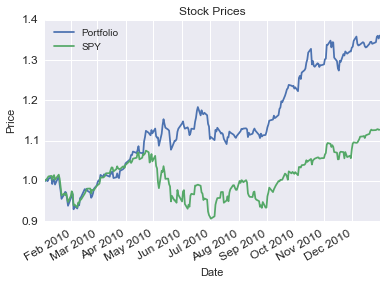

Start Date: 2010-01-01
End Date: 2010-12-31
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Allocations: [ -5.13133679e-17   3.97184082e-01   6.02815918e-01  -2.92585902e-17] 

Cumulative Return:  0.360218180403
Average Daily Return:  0.00127750880393
Volatility (stdev of daily returns):  0.0101195996551
Sharpe Ratio:  2.00401441247
End Value of Portfolio:  1360218.1804 

               SPY    GOOG    AAPL     GLD    XOM
2010-01-04  108.27  626.75  213.10  109.80  64.55
2010-01-05  108.56  623.99  213.46  109.70  64.80
2010-01-06  108.64  608.26  210.07  111.51  65.36
2010-01-07  109.10  594.10  209.68  110.82  65.15
2010-01-08  109.46  602.02  211.07  111.37  64.89


(0.36021818040251308,
 0.0012775088039260636,
 0.010119599655127669,
 2.0040144124701333,
 1360218.1804025131)

In [8]:
opitimize_portfolio(sd = '2010-01-01', ed = '2010-12-31', syms = ['GOOG', 'AAPL', 'GLD', 'XOM'])

  status: 0
 success: True
    njev: 3
    nfev: 19
     fun: 1.1866657336300404
       x: array([  7.75407672e-01,   2.24592328e-01,   5.52336599e-15,
         2.65597565e-15])
 message: 'Optimization terminated successfully.'
     jac: array([  1.96218491e-04,  -6.79835677e-04,   8.29722330e-01,
         4.10692528e-01,   0.00000000e+00])
     nit: 3
  status: 0
 success: True
    njev: 3
    nfev: 19
     fun: 1.1866657336300404
       x: array([  7.75407672e-01,   2.24592328e-01,   5.52336599e-15,
         2.65597565e-15])
 message: 'Optimization terminated successfully.'
     jac: array([  1.96218491e-04,  -6.79835677e-04,   8.29722330e-01,
         4.10692528e-01,   0.00000000e+00])
     nit: 3


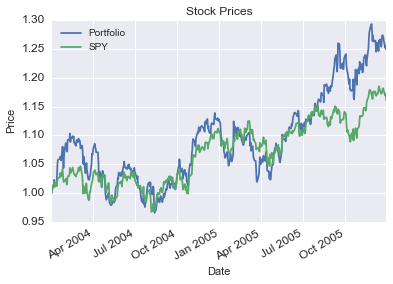

Start Date: 2004-01-01
End Date: 2006-01-01
Symbols: ['AXP', 'HPQ', 'IBM', 'HNZ']
Allocations: [  7.75407672e-01   2.24592328e-01   5.52336599e-15   2.65597565e-15] 

Cumulative Return:  0.255015025162
Average Daily Return:  0.000494932452294
Volatility (stdev of daily returns):  0.00932340614327
Sharpe Ratio:  0.842697291798
End Value of Portfolio:  1255015.02516 

              SPY    AXP    HPQ    IBM    HNZ
2004-01-02  94.28  36.66  20.93  80.43  26.84
2004-01-05  95.30  36.98  21.39  81.75  26.98
2004-01-06  95.40  37.04  21.48  81.75  27.19
2004-01-07  95.72  37.15  21.11  81.51  26.93
2004-01-08  96.10  37.04  22.31  81.74  26.90


(0.25501502516218988,
 0.0004949324522938038,
 0.009323406143267916,
 0.8426972917984029,
 1255015.02516219)

In [9]:
opitimize_portfolio(sd = '2004-01-01', ed = '2006-01-01', syms = ['AXP', 'HPQ', 'IBM', 'HNZ'])

# Part II: Build a Market Simulator

The start date and end date of the simulation are the first and last dates with orders in the orders_file. The orders_file argument is the name of a file from which to read orders, and start_val is the starting value of the portfolio (initial cash available). Return the result (portvals) as a single-column pandas.DataFrame (column name does not matter), containing the value of the portfolio for each trading day in the first column from start_date to end_date, inclusive.

The files containing orders are CSV files with the following columns:

* Date (yyyy-mm-dd)
* Symbol (e.g. AAPL, GOOG)
* Order (BUY or SELL)
* Shares (no. of shares to trade)

The market simulator should execute all the orders and see how the market value of the portfolio change.
Note that the leverage is limited up to 2, in other words, if the specific order will make the leverage go over 2, we should not execute it. 

In [10]:
def compute_portvals(orders_file, start_val = 1000000):
    """Create a market simulator that accepts trading orders, keeps track of a portfolio's value over time and then 
       assesses the performance of that portfolio.
       
    Parameters
    ----------
        orders_file: csv file that include dates, symbols (stock code), order (Buy or Sell) and number of shares
        start_val: cash holdings at the start
        
    Returns
    -------
        value_df: showing cash flow of each day and the total value of the portfolio"""
    
    orders_df = pd.read_csv(orders_file, index_col='Date', parse_dates=True, na_values=['nan'])
    orders_df.sort_index(inplace = True)
    # read in the starting and ending date
    sd = orders_df.index.values[0]
    ed = orders_df.index.values[-1]
    
    # create a dataframe containing all price info for all symbols in th order file
    dates = pd.date_range(sd, ed)
    syms = np.unique(orders_df['Symbol'])
    prices_all = get_data(syms, dates, adSPY = False)
    
    dates = prices_all.index
    syms_cash = np.append(syms, 'Cash')
    
    
    #The change in number of shares on a specific date
    trades_df = pd.DataFrame(0, columns = syms_cash, index = dates)
    
    #Accumulated numbers of shares holding and value of cash
    holdings_df = pd.DataFrame(0, columns = syms_cash, index = dates)
    holdings_df.loc[dates[0]:, 'Cash'] = start_val
    cash = start_val
    
    #Accumulated market value of each columns on each date
    values_df = pd.DataFrame(0, columns = syms_cash, index = dates)
    
    long_val = 0
    short_val = 0
    orders_dates = orders_df.index.values
    
    #Read orders into all dataframes
    for i in range(len(orders_df)):
        
    
        #see which stock is traded
        traded_stock = orders_df.ix[i, 0]
        orders_type = orders_df.ix[i, 1]
        if orders_type == "BUY":
            shares = orders_df.ix[i, 2]
            
        else:
            shares = orders_df.ix[i, 2] * -1
            
         
        trades_df.loc[orders_dates[i], traded_stock] += shares
        #Use = istead of += here so that holdings_df can update all the cashflow
        trades_df.loc[orders_dates[i], 'Cash'] = -shares * prices_all.loc[orders_dates[i], traded_stock]

        # Accumulated holdings and values
        holdings_df.loc[orders_dates[i]:, traded_stock] += shares
        holdings_df.loc[orders_dates[i]:, 'Cash'] += trades_df.loc[orders_dates[i], 'Cash']
        
        #leverage = (sum(longs) + sum(abs(shorts))) / (sum(longs) - sum(abs(shorts)) + cash)
        #Market_val is np.array of the market value of all stocks on a specific date
        market_val = holdings_df.loc[orders_dates[i], syms] * prices_all.loc[orders_dates[i]]
        cash = holdings_df.loc[orders_dates[i], 'Cash']
        leverage = np.sum(abs(market_val))/ (np.sum(market_val) + cash)

        #reversed/removed the transaction if leverage is too high
        if leverage >= 2.0:
            trades_df.loc[orders_dates[i], traded_stock] -= shares
            #Don't use += here so that holdings_df can update all the cashflow
            trades_df.loc[orders_dates[i], 'Cash'] = 0

            # Accumulated holdings and values
            holdings_df.loc[orders_dates[i]:, traded_stock] -= shares
            holdings_df.loc[orders_dates[i]:, 'Cash'] -= -shares * prices_all.loc[orders_dates[i], traded_stock]
        
    #values_df.loc[dates[i], traded_stock] = holdings_df.loc[dates[i], traded_stock] * prices_all.loc[dates[i], traded_stock]
    values_df.loc[:, 'Cash'] = holdings_df.loc[:, 'Cash']
    values_df.iloc[:, :-1] = holdings_df.iloc[:, :-1] * prices_all
    
    #Market value of the portfolio on each date
    port_daily_value = np.sum(values_df, axis = 1)
    
    # Use S&P 500 as comparison and plot the graph
    prices_spx = get_data(["$SPX"], dates, adSPY = False)
    
    #Compare the return between SPX and the portfolio
    normalized_spx = normalized(prices_spx) 
    normalized_port = normalized(port_daily_value)
    df_temp = pd.concat([normalized_port, normalized_spx], axis=1)
    df_temp.columns = ['Portfolio', '$SPX']
    df_temp.dropna(inplace = True)
                       
    plot_data(df_temp)
    
    # get portfolio statistics
    adr, cr, sddr, sr, ev = get_portfolio_stats(port_daily_value, 
                                                calculate_daily_return(port_daily_value), rfr = 0, sf = 252)
    
    # get SPX statistics
    prices_spx = prices_spx.unstack() #since the function reqiures port_daily_value column to be in Series
    adr_spx, cr_spx, sddr_spx, sr_spx, ev_spx = get_portfolio_stats(port_daily_value = prices_spx, 
                                                                    dr = calculate_daily_return(prices_spx), rfr = 0, sf = 252)
    
    
    print 'Data Range: {} to {} \n'.format(dates[0].strftime('%Y-%m-%d'), dates[-1].strftime('%Y-%m-%d'))
    
    print 'Sharpe Ratio of Fund: {}'.format(sr)
    print 'Sharpe Ratio of $SPX: {} \n'.format(sr_spx)

    print 'Cumulative Return of Fund: {}'.format(cr)
    print 'Cumulative Return of $SPX: {} \n'.format(cr_spx)
    
    print 'Standard Deviation of Fund: {}'.format(sddr)
    print 'Standard Deviation of $SPX: {} \n'.format(sddr_spx)
    
    print 'Average Daily Return of Fund: {}'.format(adr)
    print 'Average Daily Return of $SPX: {} \n'.format(adr_spx)
    
    print 'Final Portfolio Value: {} \n'.format(ev)
    
    print 'Top five rows of stock prices'
    print  prices_all.head()
    print  '\nList of Orders'
    print orders_df
    
    values_df['Portfolio Value'] = port_daily_value
    
    
    return values_df

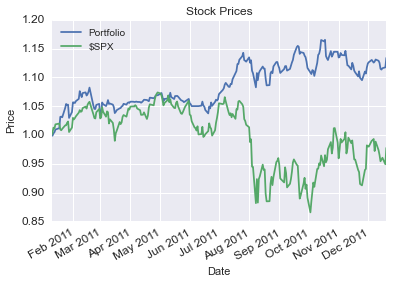

Data Range: 2011-01-10 to 2011-12-20 

Sharpe Ratio of Fund: 1.21540888742
Sharpe Ratio of $SPX: 0.0183389807444 

Cumulative Return of Fund: 0.13386
Cumulative Return of $SPX: -0.0224059854302 

Standard Deviation of Fund: 0.00720514136323
Standard Deviation of $SPX: 0.0149716091522 

Average Daily Return of Fund: 0.000551651296638
Average Daily Return of $SPX: 1.7295909534e-05 

Final Portfolio Value: 1133860.0 

Top five rows of stock prices
              AAPL    GOOG     IBM    XOM
2011-01-10  340.99  614.21  143.41  72.02
2011-01-11  340.18  616.01  143.06  72.56
2011-01-12  342.95  616.87  144.82  73.41
2011-01-13  344.20  616.69  144.55  73.54
2011-01-14  346.99  624.18  145.70  74.62

List of Orders
           Symbol Order  Shares
Date                           
2011-01-10   AAPL   BUY    1500
2011-01-13   AAPL  SELL    1500
2011-01-13    IBM   BUY    4000
2011-01-26   GOOG   BUY    1000
2011-02-02    XOM  SELL    4000
2011-02-10    XOM   BUY    4000
2011-03-03   GOOG  SELL    

,AAPL,GOOG,IBM,XOM,Cash,Portfolio Value
2011-01-10,511485,0,0,0,488515,1000000
2011-01-11,510270,0,0,0,488515,998785
2011-01-12,514425,0,0,0,488515,1002940
2011-01-13,0,0,578200,0,426615,1004815
2011-01-14,0,0,582800,0,426615,1009415
2011-01-18,0,0,585320,0,426615,1011935
2011-01-19,0,0,604880,0,426615,1031495
2011-01-20,0,0,605320,0,426615,1031935
2011-01-21,0,0,604160,0,426615,1030775
2011-01-24,0,0,620200,0,426615,1046815


In [11]:
compute_portvals(orders_file = "./orders/orders.csv", start_val = 1000000)

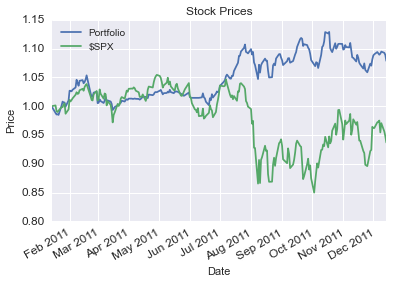

Data Range: 2011-01-14 to 2011-12-14 

Sharpe Ratio of Fund: 0.788977414925
Sharpe Ratio of $SPX: -0.177203019906 

Cumulative Return of Fund: 0.078752
Cumulative Return of $SPX: -0.0629581516192 

Standard Deviation of Fund: 0.00711101550722
Standard Deviation of $SPX: 0.0150564855724 

Average Daily Return of Fund: 0.000353423909554
Average Daily Return of $SPX: -0.000168071648902 

Final Portfolio Value: 1078752.0 

Top five rows of stock prices
              AAPL    GOOG     IBM    XOM
2011-01-14  346.99  624.18  145.70  74.62
2011-01-18  339.19  639.63  146.33  75.45
2011-01-19  337.39  631.75  151.22  75.00
2011-01-20  331.26  626.77  151.33  74.53
2011-01-21  325.32  611.83  151.04  75.71

List of Orders
           Symbol Order  Shares
Date                           
2011-01-14   AAPL   BUY    1500
2011-01-19   AAPL  SELL    1500
2011-01-19    IBM   BUY    4000
2011-01-31   GOOG   BUY    1000
2011-02-04    XOM  SELL    4000
2011-02-11    XOM   BUY    4000
2011-03-02   GOOG  SELL

,AAPL,GOOG,IBM,XOM,Cash,Portfolio Value
2011-01-14,520485,0,0,0,479515,1000000
2011-01-18,508785,0,0,0,479515,988300
2011-01-19,0,0,604880,0,380720,985600
2011-01-20,0,0,605320,0,380720,986040
2011-01-21,0,0,604160,0,380720,984880
2011-01-24,0,0,620200,0,380720,1000920
2011-01-25,0,0,627240,0,380720,1007960
2011-01-26,0,0,625680,0,380720,1006400
2011-01-27,0,0,625800,0,380720,1006520
2011-01-28,0,0,618560,0,380720,999280


In [12]:
compute_portvals(orders_file = "./orders/orders2.csv", start_val = 1000000)

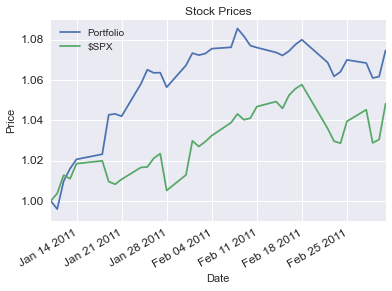

Data Range: 2011-01-10 to 2011-03-03 

Sharpe Ratio of Fund: 4.92529481246
Sharpe Ratio of $SPX: 2.65553881849 

Cumulative Return of Fund: 0.07465
Cumulative Return of $SPX: 0.0482142153967 

Standard Deviation of Fund: 0.00651837064888
Standard Deviation of $SPX: 0.00801128120646 

Average Daily Return of Fund: 0.00202241842159
Average Daily Return of $SPX: 0.00134015293001 

Final Portfolio Value: 1074650.0 

Top five rows of stock prices
              AAPL    GOOG     IBM    XOM
2011-01-10  340.99  614.21  143.41  72.02
2011-01-11  340.18  616.01  143.06  72.56
2011-01-12  342.95  616.87  144.82  73.41
2011-01-13  344.20  616.69  144.55  73.54
2011-01-14  346.99  624.18  145.70  74.62

List of Orders
           Symbol Order  Shares
Date                           
2011-01-10   AAPL   BUY    2500
2011-01-10   AAPL   BUY    2500
2011-01-13   AAPL  SELL    5000
2011-01-13    IBM   BUY    4000
2011-01-26   GOOG   BUY  100000
2011-02-02    XOM  SELL    4000
2011-02-10    XOM   BUY    400

,AAPL,GOOG,IBM,XOM,Cash,Portfolio Value
2011-01-10,1704950,0,0,0,-704950,1000000
2011-01-11,1700900,0,0,0,-704950,995950
2011-01-12,1714750,0,0,0,-704950,1009800
2011-01-13,0,0,578200,0,437850,1016050
2011-01-14,0,0,582800,0,437850,1020650
2011-01-18,0,0,585320,0,437850,1023170
2011-01-19,0,0,604880,0,437850,1042730
2011-01-20,0,0,605320,0,437850,1043170
2011-01-21,0,0,604160,0,437850,1042010
2011-01-24,0,0,620200,0,437850,1058050


In [13]:
compute_portvals(orders_file = "./orders/orders-leverage-2.csv", start_val = 1000000)

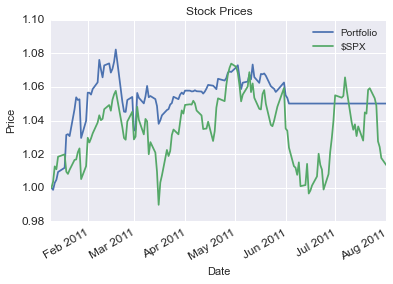

Data Range: 2011-01-10 to 2011-08-01 

Sharpe Ratio of Fund: 1.03456564947
Sharpe Ratio of $SPX: 0.247809335326 

Cumulative Return of Fund: 0.05016035
Cumulative Return of $SPX: 0.0135380980508 

Standard Deviation of Fund: 0.00560508079378
Standard Deviation of $SPX: 0.00840618502785 

Average Daily Return of Fund: 0.000365291579466
Average Daily Return of $SPX: 0.000131224926273 

Final Portfolio Value: 1050160.35 

Top five rows of stock prices
              AAPL    GOOG     IBM    XOM
2011-01-10  340.99  614.21  143.41  72.02
2011-01-11  340.18  616.01  143.06  72.56
2011-01-12  342.95  616.87  144.82  73.41
2011-01-13  344.20  616.69  144.55  73.54
2011-01-14  346.99  624.18  145.70  74.62

List of Orders
           Symbol Order  Shares
Date                           
2011-01-10   AAPL   BUY    1500
2011-01-13   AAPL  SELL    1500
2011-01-13    IBM   BUY    4000
2011-01-26   GOOG   BUY    1000
2011-02-02    XOM  SELL    4000
2011-02-10    XOM   BUY    4000
2011-03-03   GOOG  SELL

,AAPL,GOOG,IBM,XOM,Cash,Portfolio Value
2011-01-10,511485,0.00,0,0,488515,1000000.00
2011-01-11,510270,0.00,0,0,488515,998785.00
2011-01-12,514425,0.00,0,0,488515,1002940.00
2011-01-13,0,0.00,578200,0,426615,1004815.00
2011-01-14,0,0.00,582800,0,426615,1009415.00
2011-01-18,0,0.00,585320,0,426615,1011935.00
2011-01-19,0,0.00,604880,0,426615,1031495.00
2011-01-20,0,0.00,605320,0,426615,1031935.00
2011-01-21,0,0.00,604160,0,426615,1030775.00
2011-01-24,0,0.00,620200,0,426615,1046815.00


In [14]:
compute_portvals(orders_file = "./orders/orders-leverage-3.csv", start_val = 1000000)

# Part lll: Backtesting Technical Indicators

## Boolinger Bands Strategy

Bollinger Bands include (suppose N = 20):

* 20 day simple moving average (SMA) line.
* Upper Band = SMA + 2 * 20 day standard deviation.
* Lower Band = SMA - 2 * 20 day standard deviation.

A basic Bollinger Band trading strategy works as follows: 

There are two potential entries, long and short. The long entry is made when the price transitions from below the lower band to above the lower band. This indicates that the stock price has moved substantially away from the moving average, but is now moving back towards the moving average. When this entry signal criteria is met, buy the stock and hold it until the exit. The exit signal occurs when the price moves from below the SMA to above it.

The short entry and exit are mirrors of the long entry and exit: 

The short entry is made when the price transitions from above the upper band to below the upper band. This indicates that the stock price has moved substantially away from the moving average, but is now moving back towards the moving average. When this entry signal criteria is met, short the stock and hold it until the exit. The exit signal occurs when the price moves from above the SMA to below it.

In [15]:
def generate_orders_csv(df, syms, shares, column = 'Order'):
    """Retrieve the orders from the dataframe and turn into the CSV file that the function 
        "compute_portvals(orders_file, start_val = 1000000)" accepts.
       
    Parameters
    ----------
        df: datafram with columns including the stock name and the orders to be placed
        syms: a symbol. One stock in the cases in part III
        shares: number of shares we want to place for each order
        column: indicate the column that contains the market order 
        
    Returns
    -------
        orders_name: the CSV file name of the orders book with four columns: ['Date','Symbol', 'Order', 'Shares']
        """
    order = pd.DataFrame(columns = ['Date','Symbol', 'Order', 'Shares'])
    df_filter = df[df[column] != 'NaN']
    order['Date'] = df_filter.index
    order['Order'] = df_filter[column].values
    order['Symbol'] = syms
    order['Shares'] = shares
    
    orders_name = 'orders_' + syms + '.csv';
    order.to_csv(orders_name, index = False)
    
    return orders_name

In [16]:
def boolinger_strategy(sd, ed, syms, N = 20):
    """Given range of trading dates and stocks, the function will find out N-day Simple Moving Averge (SMA)
        and Bollinger Bands and track the signal of indicators to generate corresponding order.
       
    Parameters
    ----------
        sd: first date to track
        ed: last date to track
        syms: symbols, a list of stock names
        N: Using N days of simple moving average and standard deviation
        
    Returns
    -------
        BB: dataframe with columns of ['Price', 'SMA', 'Upper Band', 'Lower Band', 'Score', 'Order', 'Holding']
            where 'SMA', 'Upper Band', 'Lower Band' are used to compute the band, 'Score' is used to measure overbuy (score > 1)
            and oversell (score < -1), 'Order' is to indicate the BUY/SELL order and 'Holding' show whethers we are holding a
            portfolio.
        """
    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    prices = get_data(syms, dates, adSPY = False)
    
    BB = pd.DataFrame(np.zeros((len(prices) , 7)), columns = ['Price', 'SMA', 'Upper Band', 'Lower Band', 'Score', 'Order', 'Holding'],
                      index = prices.index)
    
    BB['Price'] = prices
    BB['Order'] = 'NaN'
    BB['Holding'] = False
    
    holding_stock = False
    position = 0
    for i in range(len(prices)):
        if i >= N - 1:
            #SMA
            BB.iloc[i, 1] = float(prices.iloc[i -(N-1): i+1].mean())
        
            std = float(np.std(prices.iloc[i - (N-1): i+1], ddof = 1))
            
            #Upper Band
            BB.iloc[i, 2] = float(BB.iloc[i, 1] + 2 * std)
            #Lower Band
            BB.iloc[i, 3] = float(BB.iloc[i, 1] - 2 * std)
            
            #Score
            BB.iloc[i, 4] = float(((prices.iloc[i]) - BB.iloc[i, 1]) / (2*std))
            
            
            if not holding_stock:
            
                if (BB.iloc[i-1, 4]> 1.0) and (BB.iloc[i, 4] < 1.0):
                    #Order
                    BB.iloc[i, 5] = 'SELL'
                    holding_stock = True
                    position = -1
                elif (BB.iloc[i-1, 4] < -1.0) and (BB.iloc[i, 4] > -1.0):
                    BB.iloc[i, 5] = 'BUY'
                    holding_stock = True
                    position = 1
            else:
                if position==-1 and (BB.iloc[i-1, 4] > 0.0) and (BB.iloc[i, 4] < 0.0):
                    BB.iloc[i, 5] = 'BUY'
                    holding_stock = False
                    position = 0
                elif position == 1 and (BB.iloc[i-1, 4] < 0.0) and (BB.iloc[i, 4] > 0.0):
                    BB.iloc[i, 5] = 'SELL'
                    holding_stock = False  
                    position = 0
            #Holding        
            BB.iloc[i, 6] = holding_stock
        else:
            BB[['SMA', 'Upper Band', 'Lower Band']] = np.nan
            
  
    fig = plt.figure(figsize = (20, 16))
    
    #BB = BB[BB['Order'] != 'NaN']
    
    sell = BB[np.array(BB['Order'] == 'SELL') & np.array(BB['Holding'])].index
    buy = BB[np.array(BB['Order'] == 'BUY') & np.array(BB['Holding'])].index
    closed = BB[np.invert(np.array(BB['Holding'])) & np.array(BB['Order'] != 'NaN')].index
    
    
    ax = BB[['SMA', 'Upper Band', 'Lower Band', 'Price']].plot()
    
    ymin, ymax = ax.get_ylim()
    ax.vlines(x= sell, ymin=ymin, ymax=ymax-1, color='r', lw = 0.5)
    ax.vlines(x= buy, ymin=ymin, ymax=ymax-1, color='g', lw = 0.5)
    ax.vlines(x= closed, ymin=ymin, ymax=ymax-1, color='black', lw = 0.5)
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    
    return BB

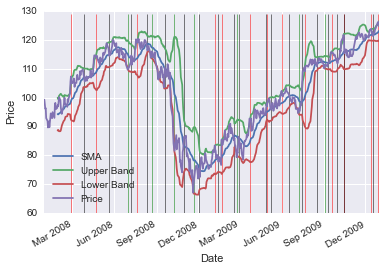

             Price       SMA  Upper Band  Lower Band     Score Order Holding
2007-12-31   99.27       NaN         NaN         NaN  0.000000   NaN   False
2008-01-02   96.14       NaN         NaN         NaN  0.000000   NaN   False
2008-01-03   96.34       NaN         NaN         NaN  0.000000   NaN   False
2008-01-04   92.87       NaN         NaN         NaN  0.000000   NaN   False
2008-01-07   91.88       NaN         NaN         NaN  0.000000   NaN   False
2008-01-08   89.62       NaN         NaN         NaN  0.000000   NaN   False
2008-01-09   90.28       NaN         NaN         NaN  0.000000   NaN   False
2008-01-10   91.76       NaN         NaN         NaN  0.000000   NaN   False
2008-01-11   89.70       NaN         NaN         NaN  0.000000   NaN   False
2008-01-14   94.53       NaN         NaN         NaN  0.000000   NaN   False
2008-01-15   93.52       NaN         NaN         NaN  0.000000   NaN   False
2008-01-16   93.33       NaN         NaN         NaN  0.000000   NaN   False

In [17]:
BB = boolinger_strategy(sd = '2007-12-31', ed = '2009-12-31', syms = ['IBM'], N = 20)
print BB

In [18]:
orders_name = generate_orders_csv(BB, 'IBM', 100)
print orders_name
file_dir = "./" + orders_name

orders_IBM.csv


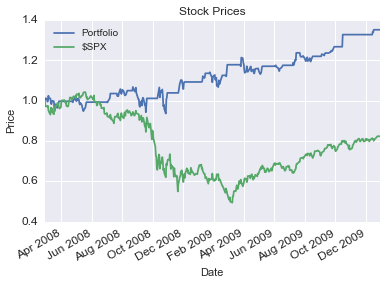

Data Range: 2008-02-28 to 2009-12-29 

Sharpe Ratio of Fund: 1.00195922396
Sharpe Ratio of $SPX: -0.116052774605 

Cumulative Return of Fund: 0.3524
Cumulative Return of $SPX: -0.176561768835 

Standard Deviation of Fund: 0.0113472713465
Standard Deviation of $SPX: 0.0225771006222 

Average Daily Return of Fund: 0.000716211380412
Average Daily Return of $SPX: -0.000165053001441 

Final Portfolio Value: 13524.0 

Top five rows of stock prices
               IBM
2008-02-28  106.24
2008-02-29  104.96
2008-03-03  105.30
2008-03-04  106.67
2008-03-05  106.37

List of Orders
           Symbol Order  Shares
Date                           
2008-02-28    IBM  SELL     100
2008-03-27    IBM   BUY     100
2008-04-22    IBM  SELL     100
2008-05-21    IBM   BUY     100
2008-07-01    IBM   BUY     100
2008-07-08    IBM  SELL     100
2008-07-21    IBM  SELL     100
2008-08-11    IBM   BUY     100
2008-08-21    IBM   BUY     100
2008-09-19    IBM  SELL     100
2008-10-10    IBM   BUY     100
2008-10-

,IBM,Cash,Portfolio Value
2008-02-28,-10624,20624,10000
2008-02-29,-10496,20624,10128
2008-03-03,-10530,20624,10094
2008-03-04,-10667,20624,9957
2008-03-05,-10637,20624,9987
2008-03-06,-10373,20624,10251
2008-03-07,-10504,20624,10120
2008-03-10,-10510,20624,10114
2008-03-11,-10739,20624,9885
2008-03-12,-10792,20624,9832


In [19]:
compute_portvals(orders_file = file_dir, start_val = 10000)

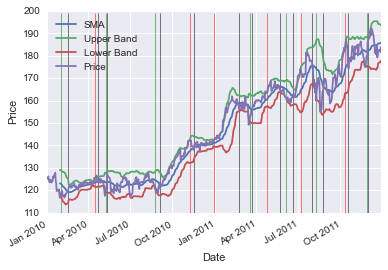

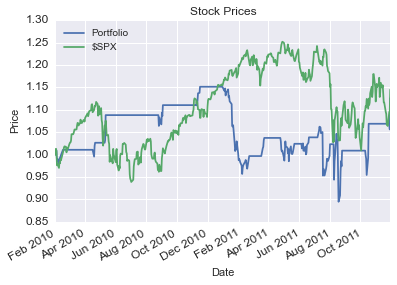

Data Range: 2010-02-01 to 2011-11-30 

Sharpe Ratio of Fund: 0.427702655439
Sharpe Ratio of $SPX: 0.454866937848 

Cumulative Return of Fund: 0.126
Cumulative Return of $SPX: 0.144850760657 

Standard Deviation of Fund: 0.0123726224413
Standard Deviation of $SPX: 0.0132785665816 

Average Daily Return of Fund: 0.00033335228515
Average Daily Return of $SPX: 0.000380483034234 

Final Portfolio Value: 11260.0 

Top five rows of stock prices
               IBM
2010-02-01  118.82
2010-02-02  119.64
2010-02-03  119.76
2010-02-04  117.23
2010-02-05  117.73

List of Orders
           Symbol Order  Shares
Date                           
2010-02-01    IBM   BUY     100
2010-02-16    IBM  SELL     100
2010-04-16    IBM  SELL     100
2010-04-21    IBM   BUY     100
2010-05-10    IBM   BUY     100
2010-05-12    IBM  SELL     100
2010-08-25    IBM   BUY     100
2010-09-03    IBM  SELL     100
2010-11-08    IBM  SELL     100
2010-11-16    IBM   BUY     100
2010-12-30    IBM  SELL     100
2011-02-22  

,IBM,Cash,Portfolio Value
2010-02-01,11882,-1882,10000
2010-02-02,11964,-1882,10082
2010-02-03,11976,-1882,10094
2010-02-04,11723,-1882,9841
2010-02-05,11773,-1882,9891
2010-02-08,11668,-1882,9786
2010-02-09,11795,-1882,9913
2010-02-10,11757,-1882,9875
2010-02-11,11845,-1882,9963
2010-02-12,11871,-1882,9989


In [20]:
BB2 = boolinger_strategy(sd = '2009-12-31', ed = '2011-12-31', syms = ['IBM'], N = 20)
orders_name = generate_orders_csv(BB2, 'IBM', 100)

file_dir = "./" + orders_name
compute_portvals(orders_file = file_dir, start_val = 10000)

#Moving Average Convergence / Divergence (MACD)

Definition of MACD:

* MACD Line: (12-day EMA - 26-day EMA)
* Signal Line: 9-day EMA of MACD Line
* MACD Divergence/Histogram: MACD Line - Signal Line

### Signal Line Crossovers

Signal line crossovers are the most common MACD signals. The signal line is a 9-day EMA of the MACD Line. As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns. A bullish crossover occurs when the MACD turns up and crosses above the signal line. We go long when the bullish crossover appear together with MACD < 0. A bearish crossover occurs when the MACD turns down and crosses below the signal line. In this case, we go short as MACD > 0 holds at the same time.

In [21]:
def EMA(prices, N):
    """Calculate N-day Exponential Moving Average with the following formula:
        k: (2 / (Time periods(N) + 1) )
        EMA: {Close - EMA(previous day)} x k + EMA(previous day). 
       
    Parameters
    ----------
        prices: stock prices
        N: time period for EMA
        
    Returns
    -------
        EMA: N-day EMA
        """
    EMA = prices.copy()
    k = 2.0 / (N+1)
    
    for i in range(len(prices)):
        if i < N-1:
            EMA.iloc[i] = np.nan
        elif i == N-1:
            EMA.iloc[i] = prices.iloc[i]
        else:
            EMA.iloc[i] = prices.iloc[i] * k + EMA.iloc[i-1] * (1- k)
    return EMA                   

In [22]:
def MACD_strategy(sd, ed, syms):
    """Given range of trading dates and stocks, the function calculate MACD and generate orders when 
        golden/death cross of MACD and signal line appear.
       
    Parameters
    ----------
        sd: first date to track
        ed: last date to track
        syms: symbols, a list of stock names
        
    Returns
    -------
        MACD: Dataframe with columns as ['Price', 'MACD', 'Signal', 'Order', 'Holding', 'Divergence']
        """
    # Read in adjusted closing prices for given symbols, date range
    dates = pd.date_range(sd, ed)
    prices = get_data(syms, dates, adSPY = False)
    
    MACD = pd.DataFrame(np.zeros((len(prices) , 6)), columns = ['Price', 'MACD', 'Signal', 'Order', 'Holding', 'Divergence'],
                      index = prices.index)
   
    MACD['Price'] = prices
    MACD['Order'] = 'NaN'
    MACD['Holding'] = False
    
    MACD['MACD'] = EMA(prices, 12) - EMA(prices, 26)
    MACD['Signal'] = EMA(MACD.iloc[25:, 1], 9)
    MACD['Divergence'] = MACD['MACD'] - MACD['Signal']
    
    holding_stock = False
    pos = 0
    for i in range(len(prices)):
        #if i >= N - 1:
        
        #MACD < 0
        k = 0.5
        if not holding_stock:
            
            if (MACD.iloc[i, 1] < 0 and MACD.iloc[i-1, 1] < MACD.iloc[i-1, 2] and MACD.iloc[i, 1] > MACD.iloc[i, 2]):
                MACD.iloc[i, 3] = 'BUY'
                holding_stock = True
                pos = 1
                
            elif (MACD.iloc[i, 1] > 0 and MACD.iloc[i-1, 1] > MACD.iloc[i-1, 2] and MACD.iloc[i, 1] < MACD.iloc[i, 2]):
                MACD.iloc[i, 3] = 'SELL'
                holding_stock = True
                pos = -1
        #closed the position
        else:
            if pos == 1 and (MACD.iloc[i, 1] > 0 and MACD.iloc[i-1, 1] > MACD.iloc[i-1, 2] and MACD.iloc[i, 1] < MACD.iloc[i, 2]):
                MACD.iloc[i, 3] = 'SELL'
                holding_stock = False
                pos = 0
                
            elif pos == -1 and (MACD.iloc[i, 1] < 0 and MACD.iloc[i-1, 1] < MACD.iloc[i-1, 2] and MACD.iloc[i, 1] > MACD.iloc[i, 2]):
                MACD.iloc[i, 3] = 'BUY'
                holding_stock = False
                pos = 0
                
        MACD.iloc[i, 4] = holding_stock    
  
    fig = plt.figure(figsize = (20, 16))
    
    sell = MACD[np.array(MACD['Order'] == 'SELL') & np.array(MACD['Holding'])].index
    buy = MACD[np.array(MACD['Order'] == 'BUY') & np.array(MACD['Holding'])].index
    closed = MACD[np.invert(np.array(MACD['Holding'])) & np.array(MACD['Order'] != 'NaN')].index
    
    
    #ax1 = fig.add_subplot(1, 2, 1)
    
    
    #ax2 = fig.add_subplot(1, 2, 2)
    ax1 = MACD[['MACD', 'Signal']].plot()
    ymin, ymax = ax1.get_ylim()
    ax1.vlines(x= sell, ymin=ymin, ymax=ymax-1, color='r', lw = 0.5)
    ax1.vlines(x= buy, ymin=ymin, ymax=ymax-1, color='g', lw = 0.5)
    ax1.vlines(x= closed, ymin=ymin, ymax=ymax-1, color='black', lw = 0.5)
    
    plt.show()
    
    ax2 = MACD[['Price']].plot()
    ymin, ymax = ax2.get_ylim()
    ax2.vlines(x= sell, ymin=ymin, ymax=ymax-1, color='r', lw = 0.5)
    ax2.vlines(x= buy, ymin=ymin, ymax=ymax-1, color='g', lw = 0.5)
    ax2.vlines(x= closed, ymin=ymin, ymax=ymax-1, color='black', lw = 0.5)
    
    #plt.xlabel('Date')
    #plt.ylabel('Price')
    plt.show()
    
    
    return MACD

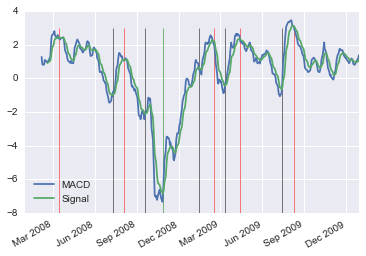

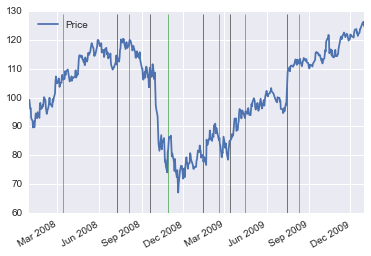

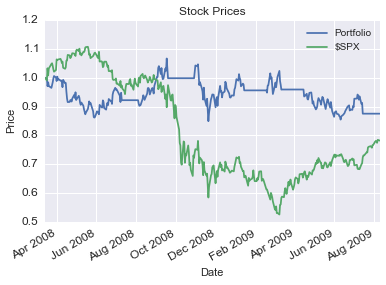

Data Range: 2008-03-14 to 2009-08-10 

Sharpe Ratio of Fund: -0.254878550957
Sharpe Ratio of $SPX: -0.241960260299 

Cumulative Return of Fund: -0.1247
Cumulative Return of $SPX: -0.218175043085 

Standard Deviation of Fund: 0.015738592936
Standard Deviation of $SPX: 0.0250564678099 

Average Daily Return of Fund: -0.000252696322645
Average Daily Return of $SPX: -0.000381912278762 

Final Portfolio Value: 8753.0 

Top five rows of stock prices
               IBM
2008-03-14  106.23
2008-03-17  106.52
2008-03-18  109.16
2008-03-19  107.80
2008-03-20  109.08

List of Orders
           Symbol Order  Shares
Date                           
2008-03-14    IBM  SELL     100
2008-07-10    IBM   BUY     100
2008-08-04    IBM  SELL     100
2008-09-19    IBM   BUY     100
2008-10-29    IBM   BUY     100
2009-01-14    IBM  SELL     100
2009-02-17    IBM  SELL     100
2009-03-13    IBM   BUY     100
2009-04-15    IBM  SELL     100
2009-07-15    IBM   BUY     100
2009-08-10    IBM  SELL     100


,IBM,Cash,Portfolio Value
2008-03-14,-10623,20623,10000
2008-03-17,-10652,20623,9971
2008-03-18,-10916,20623,9707
2008-03-19,-10780,20623,9843
2008-03-20,-10908,20623,9715
2008-03-24,-10976,20623,9647
2008-03-25,-10875,20623,9748
2008-03-26,-10778,20623,9845
2008-03-27,-10649,20623,9974
2008-03-28,-10562,20623,10061


In [23]:
MACD = MACD_strategy('2007-12-31', '2009-12-31', ['IBM'])
orders_name = generate_orders_csv(MACD, 'IBM', 100)
file_dir = "./" + orders_name

compute_portvals(orders_file = file_dir, start_val = 10000)